In [1]:
%matplotlib inline
import sys
sys.path.insert(0,'..')
from IPython.display import HTML,Image,SVG,YouTubeVideo
from helpers import header

HTML(header())

# Histogram

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from skimage.data import camera,lena
plt.style.use('ggplot')

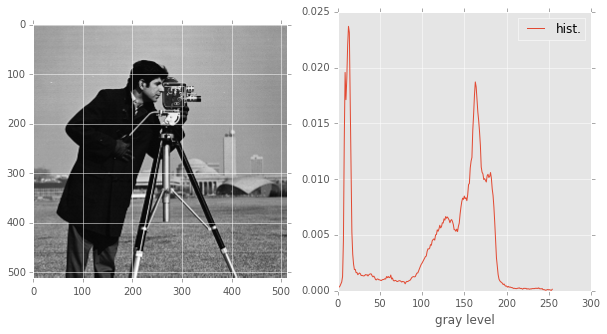

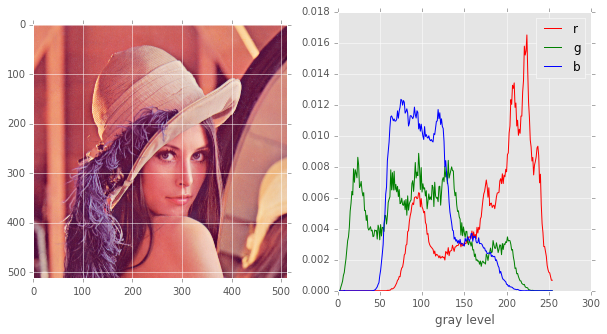

In [3]:
def norm_hist(ima):
    hist,bins = np.histogram(ima.flatten(),range(256))  # histogram is computed on a 1D distribution --> flatten()
    return 1.*hist/np.sum(hist) # normalized histogram

def display_hist(ima):
    plt.figure(figsize=[10,5])
    if ima.ndim == 2:
        nh = norm_hist(ima)
    else:
        nh_r = norm_hist(ima[:,:,0])
        nh_g = norm_hist(ima[:,:,1])
        nh_b = norm_hist(ima[:,:,2])
    # display the results
    plt.subplot(1,2,1)
    plt.imshow(ima,cmap=cm.gray)
    plt.subplot(1,2,2)
    if ima.ndim == 2:
        plt.plot(nh,label='hist.')
    else:
        plt.plot(nh_r,color='r',label='r')
        plt.plot(nh_g,color='g',label='g')
        plt.plot(nh_b,color='b',label='b')
    plt.legend()
    plt.xlabel('gray level');
    
display_hist(camera())
display_hist(lena())

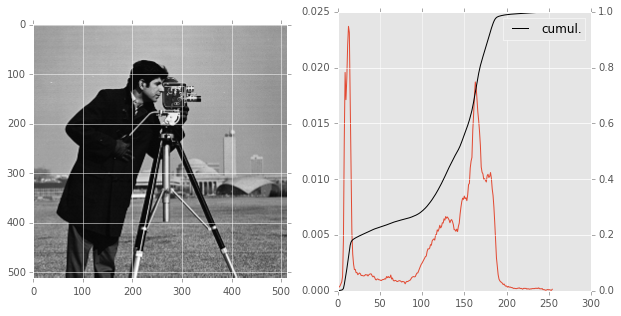

In [4]:
def display_hist2(ima):
    nh = norm_hist(ima)
    cumul_hist = np.cumsum(nh)
    
    plt.figure(figsize=[10,5])
    plt.subplot(1,2,1)
    plt.imshow(ima,cmap=cm.gray)
    ax1 = plt.subplot(1,2,2)
    plt.plot(nh)
    ax2 = ax1.twinx()
    plt.plot(cumul_hist,label='cumul.',color='k')
    plt.legend()
    
display_hist2(camera())

# Look-Up-Table

Example are given for 8-bits images but can of course be generalized for any kind of integer image, however, due to memory limitation, LUT method will be used only with bit-depth limited images.

In [5]:
def apply_lut(ima,lut):
    nh = norm_hist(ima)
    lima = lut[ima]
    nh_lima = norm_hist(lima)
    
    plt.figure(figsize=[10,5])
    plt.subplot(1,2,1)
    plt.imshow(lima,cmap=cm.gray)
    ax1 = plt.subplot(1,2,2)
    plt.plot(nh,label='ima')
    plt.plot(nh_lima,label='lut[ima]')
    plt.legend(loc='upper left')
    ax2 = ax1.twinx()
    plt.plot(lut,label='lut',color='k')
    plt.legend()

## Negative

$$g_{out} = 255 - g_{in}$$

To apply this inversion tp the complete image, one use the Look Up Table (LUT) method which consist in pre-computng the transformed levels for all the 255 possible gray level into one vector. Image transformation is then a simple vector addressing.

<code>
lut = np.arange(255,-1,-1)
g_out = lut[g_in]
</code>

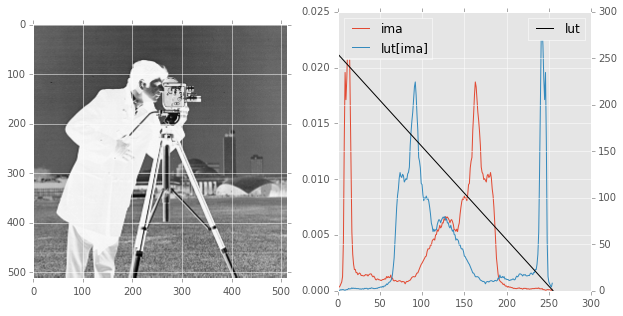

In [6]:
# LUT invertion    
ima = camera()
lut = np.arange(255,-1,-1)
apply_lut(ima,lut)

## Threshold
Look up table for a simple threshold is:

$$g_{out} = \begin{cases} 255, & \mbox{if }g_{in}>th\\
0, & \mbox{otherwise}\end{cases}$$


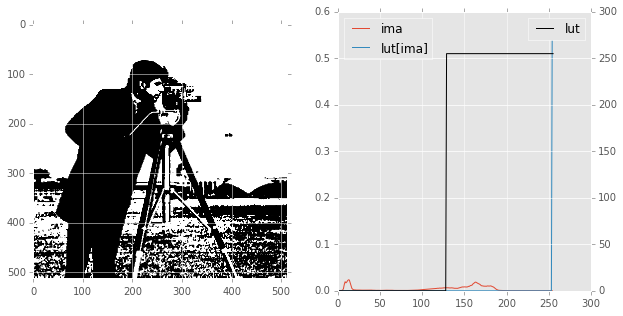

In [7]:
def lut_threshold(th):
    lut = np.arange(0,256)
    lut = 255 * (lut > th)
    return lut 

apply_lut(ima,lut_threshold(128))


## Semi-threshold
Look up table for a simple threshold is:

$$g_{out} = \begin{cases} g_{in}, & \mbox{if }g_{in}>th\\
0, & \mbox{otherwise}\end{cases}$$


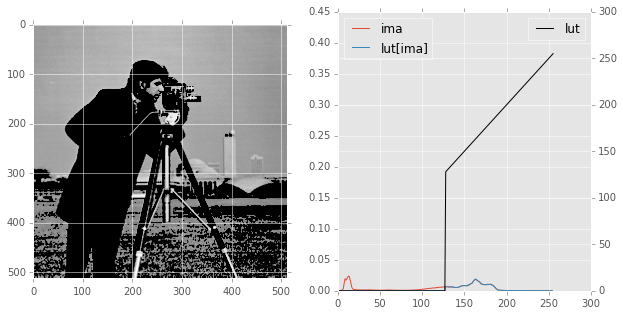

In [8]:
def lut_semi_threshold(th):
    lut = np.arange(0,256)
    lut[lut < th] = 0
    return lut 

apply_lut(ima,lut_semi_threshold(128))


## Gamma correction
Gamma transform is used to reinforce contrast of the image, level trasform is given by:

$$g_{out} = A \: g_{in}^{\gamma}$$ where $$ A = 255^{(1-\gamma)}$$

if $\gamma < 1$ the low-level are contrasted, reversely if $\gamma >1$ bright part of the image gains in contrast.


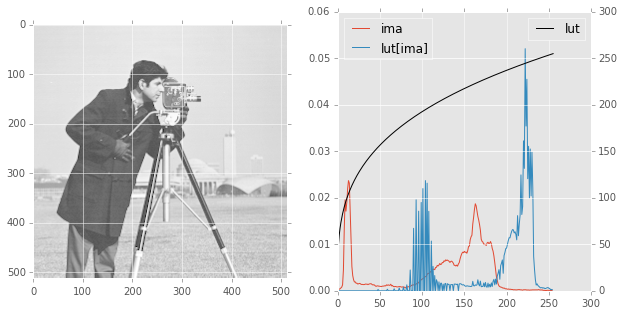

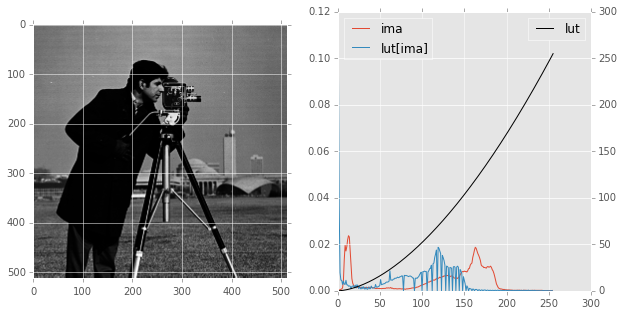

In [9]:
def lut_gamma(gamma):
    lut = np.power(np.arange(0,256),gamma) * np.power(255,1-gamma)
    return lut 

apply_lut(ima,lut_gamma(.3))
apply_lut(ima,lut_gamma(1.7))


## Auto-level
Auto-level map the complete image dynamic to the full dynamic scale:

$$g_{out} = 255 \frac{g_{in} - g_{min}}{g_{max}-g_{min}}$$

where $g_{min}$ and $g_{max}$ are respectively minimimal and maximal value present in the image.

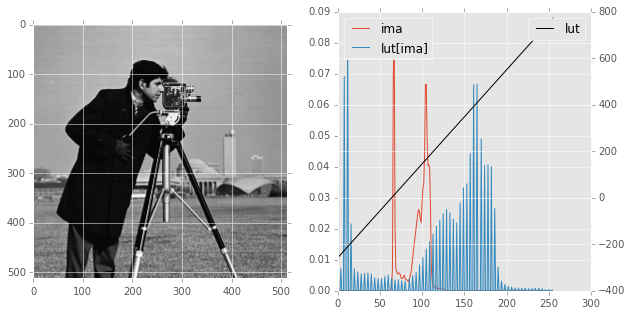

In [10]:
def lut_autolevel(ima):
    g_min = np.min(ima)
    g_max = np.max(ima)
    lut = 255*(np.arange(0,256)-g_min)/(1.*g_max-g_min)
    return lut
t_ima = (ima/4+64).astype(np.uint8)
apply_lut(t_ima,lut_autolevel(t_ima))

## Equalization

One may be interested in using as many gray levels possible for frequent levels, and in grouping rare levels. This is called histogram equalization since, after the operation, the histogram distribution is more equal.

The next figure illustrate equalization done of the cameraman picture. 

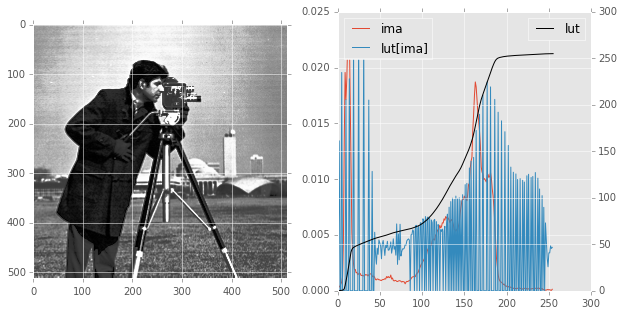

In [11]:
def lut_equalization(ima):
    nh = norm_hist(ima)
    ch = np.append(np.array(0),np.cumsum(nh))
    lut = 255*ch
    return lut
apply_lut(ima,lut_equalization(ima))

We can see that levels frequently observed (in the sky) are now more spread (more contrast is visible), the same inside the cameraman where details are now visible (hand).
The histogram is not perctly equal, this is due to the technique used (the look up table), indeed pixel having an equal gray level are transform similarily, they cannot be separated.

If we look to the code used to achieve the equalization, we see that we simply used, as look up table, the summed histogram !

Here is the justification of that:

* the gray level(arbitrarily set in $[0,1]$) probability is given by:

$$p_r(r) = \frac{n_r}{n}\\
0 \le r \le 1\\
$$

where $n_r$ is the number of pixels having the value $r$ anf $n$ the total number of image pixels.

* let's consider a transform $T$ that maps graylevels $r$ to graylevel $s$,
$T(r)$ is considered as monotically increasing on $0 \le r \le 1$.

$$\begin{align}
s&=T(r)\\
0 \le &T(r) \le 1\\
r &= T{-1}(s)
\end{align}
$$

We also assume that $T{-1}(s)$ is monotically increasing on $0 \le s \le 1$ and bounded to $[0,1]$.

* from probability theory, the probability density function of the transformed gray level is:

$$p_s(s) = \Big[p_r(r)\frac{dr}{ds}\Big]_{r=T^{-1}(s)}$$

* if we consider the following transform function:

$$ s = T(r) = \int _0 ^r p_r(w) dw \qquad 0 \le r \le 1$$

* then

$$\frac{ds}{dr} = p_r(r)$$

* we can substitute this fraction in the previous equation:

$$\begin{align}
p_s(s) &= \Big[p_r(r)\frac{1}{p_r(r)}\Big]_{r=T^{-1}(s)} \\
&= \Big[1\Big]_{r=T^{-1}(s)} \\
&= 1 \qquad 0 \le s \le 1
\end{align}
$$

which is uniform on the interval.

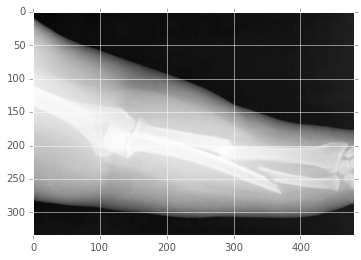

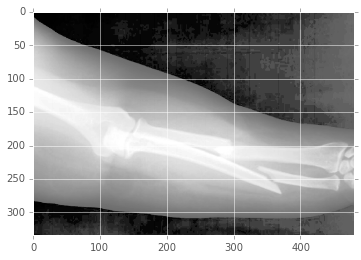

In [12]:
#other example
from skimage.io import imread
ima = imread('http://homepages.ulb.ac.be/~odebeir/data/bones.png')
lut = lut_equalization(ima)
plt.figure()
plt.imshow(ima,cmap=cm.gray)
plt.figure()
plt.imshow(lut[ima],cmap=cm.gray);




if we need to increase the conrtrast in a certain part of the image, equalization LUT may be restricted to a certain area:

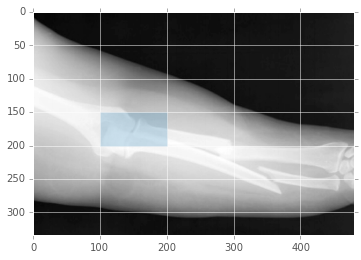

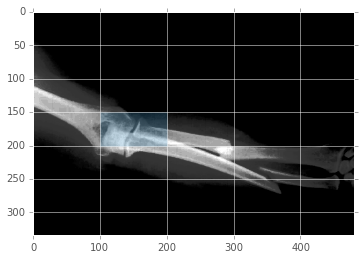

In [13]:
roi = [(100,150),100,50]
sample = ima[roi[0][1]:roi[0][1]+roi[2],roi[0][0]:roi[0][0]+roi[1]]
lut = lut_equalization(sample)

plt.figure()
plt.imshow(ima,cmap=cm.gray)
rect = plt.Rectangle(*roi, facecolor=None,alpha=.25)
plt.gca().add_patch(rect)


plt.figure()
plt.imshow(lut[ima],cmap=cm.gray);
rect = plt.Rectangle(*roi, facecolor=None,alpha=.25)

plt.gca().add_patch(rect);



>see also:
* histogram based methods [IPAMV](../00-Preface/06-References.ipynb#[IPAMV]) pp58-61